<a href="https://colab.research.google.com/github/lauraemmanuella/TCCPUCMinas/blob/main/cienciadados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de conclusão de curso



---



PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS

NÚCLEO DE EDUCAÇÃO À DISTÂNCIA 

Pós-graduação *Lato Sensu* em Ciência de Dados e Big Data



---



**Laura Emmanuella Alves dos Santos Santana**

> **PREDIÇÃO DE GÊNERO PARA RECOMENDAÇÃO DE LIVROS: UM ESTUDO DE CASO A PARTIR DA PLATAFORMA SKOOB**




---


Belo Horizonte, 2021

# Bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np

import re
from bs4 import BeautifulSoup
import requests as rq

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss 
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics

from scipy import stats

# 1 - Análise e processamento da base Livros Skoob disponível no Kaggle

https://www.kaggle.com/victorstein/livros-skoob

In [ ]:
#Carrega a base adquirida no Kaggle
df = pd.read_csv('./dados.csv')

In [ ]:
# mostra quantidade de amostras
# mostra quantidade de colunas
# mostra os nomes das colunas
print('*************************************************************************')
print(f'Número de amostras: {df.shape[0]}')
print(f'Número de Colunas: {df.shape[1]}')
print(f'Nomes das Colunas: {df.columns.values}')
print('*************************************************************************')

*************************************************************************
Número de amostras: 11975
Número de Colunas: 20
Nomes das Colunas: ['titulo' 'autor' 'ISBN_13' 'ISBN_10' 'ano' 'paginas' 'idioma' 'editora'
 'rating' 'avaliacao' 'resenha' 'abandonos' 'relendo' 'querem_ler' 'lendo'
 'leram' 'descricao' 'genero' 'male' 'female']
*************************************************************************


In [ ]:
#mostra tipo de dados das colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11975 entries, 0 to 11974
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   titulo      11975 non-null  object 
 1   autor       11971 non-null  object 
 2   ISBN_13     11216 non-null  float64
 3   ISBN_10     11216 non-null  object 
 4   ano         11975 non-null  int64  
 5   paginas     11975 non-null  int64  
 6   idioma      11973 non-null  object 
 7   editora     11974 non-null  object 
 8   rating      11975 non-null  float64
 9   avaliacao   11975 non-null  int64  
 10  resenha     11975 non-null  int64  
 11  abandonos   11975 non-null  int64  
 12  relendo     11975 non-null  int64  
 13  querem_ler  11975 non-null  int64  
 14  lendo       11975 non-null  int64  
 15  leram       11975 non-null  int64  
 16  descricao   11318 non-null  object 
 17  genero      11386 non-null  object 
 18  male        11975 non-null  int64  
 19  female      11975 non-nul

In [ ]:
#verifica quantas amostras possuem valor NaN por coluna
df.isna().sum() 

titulo          0
autor           4
ISBN_13       759
ISBN_10       759
ano             0
paginas         0
idioma          2
editora         1
rating          0
avaliacao       0
resenha         0
abandonos       0
relendo         0
querem_ler      0
lendo           0
leram           0
descricao     657
genero        589
male            0
female          0
dtype: int64

In [ ]:
#Coluna gênero, indica os gêneros literários do livro
df['genero']

0        Economia, Finanças / Literatura Brasileira / N...
1        Drama / Ficção / Literatura Estrangeira / Susp...
2        Ficção / Ficção científica / Literatura Estran...
3        Biografia, Autobiografia, Memórias / História ...
4        Ficção / HQ, comics, mangá / Literatura Estran...
                               ...                        
11970            Literatura Estrangeira / Poemas, poesias 
11971                      Ficção / Literatura Brasileira 
11972    Aventura / Cinema / Crime / Crônicas / Drama /...
11973            Literatura Estrangeira / Poemas, poesias 
11974                          Religião e Espiritualidade 
Name: genero, Length: 11975, dtype: object

In [ ]:
#remove as linhas onde na coluna genero tem NaN
df.dropna(subset=['genero'], inplace=True)
#Explicação: a coluna gênero possui uma string com os nomes dos gêneros literários do livro (ex: ficção, infantojuvenil, etc.)
#Essa coluna será usada para preencher as novas colunas com os gêneros literários separadamente
#sendo assim, as amostras sem essa informação não interessam

In [ ]:
#remove as linhas onde o titulo é duplicado, mantendo a primeira ocorrência
#apesar de serem edições diferentes, mas os demais dados são praticamente os mesmos
df.drop_duplicates(subset=['titulo'], keep='first', inplace=True)
#Explicação: evitar amostras repetidas

In [ ]:
#Quantidade de amostras atual
print(f'Atualizando: {df.shape[0]} amostras')

Atualizando: 10153 amostras


In [ ]:
#Lista com nomes de gêneros literários comuns
generosLiterarios = ['adulto', 'artes', 'autoajuda', 'aventura', 'biografia', 'comunicação', 'contos', 'crime', 'crônica', 'culinária', 'decoração', 'drama', 'economia', 'ensaios', 'entretenimento', 'erótico', 'fantasia', 'ficção', 'filosofia', 'história', 'infantil', 'infantojuvenil', 'brasileira', 'estrangeira', 'matemática', 'memórias', 'música', 'não-ficção', 'poesias', 'policial', 'política', 'psicologia', 'religião', 'romance', 'saúde', 'sexo', 'sociologia', 'suspense', 'terror', 'viagens']

In [ ]:
#Adiciona coluna para cada gênero da lista anterior com valor 0
for i in generosLiterarios:
  df.loc[:, i] = 0

In [ ]:
#Percorre as linhas do dataframe, verificando os termos presentes na coluna genero
#Coloca o valor 1 nas colunas com os gêneros correspondentes
#Exemplo, se na coluna genero tiver: "drama, contos, adulto", então nessas 3 colunas será colocado o valor 1
for row in df.itertuples():
  lista = re.split(r'[\s,]+',str(row.genero)) #separa por espaço em branco e vírgula
  for item in lista:
    nome = item.lower().strip()
    if nome in generosLiterarios:
      df.loc[row.Index, nome] = 1

In [ ]:
#Verifica se a coluna male é maior, menor ou igual a coluna female
#retorna M quando male for maior, F quando female for maior e UNKNOWN quando for igual
def acha_classe(registro):
    if registro['male'] > registro['female']:
        return 'M'
    elif registro['male'] < registro['female']:
        return 'F'
    else:
        return 'UNKNOWN'
#Explicação: Será gerada uma coluna chamada gender para ser a coluna alvo no processo de aprendizado de máquina
#essa coluna possuirá o valor M quando a maioria dos leitores for male e F quando a maioria for female

In [ ]:
#Adiciona coluna gender com os valores retornados pela função acha_classe
df['gender'] = df.apply(acha_classe, axis=1)

In [ ]:
df['gender'].value_counts()

F          8655
M          1290
UNKNOWN     208
Name: gender, dtype: int64

In [ ]:
# Pega os nomes dos índices para cada coluna gender com valor UNKNOWN
indexNames = df[ df['gender'] == 'UNKNOWN' ].index
#Apaga as linhas com os índices identificados do dataframe
df.drop(indexNames , inplace=True)
#Explicação: Remover as amostras onde Male e Female tem a mesma proporção

In [ ]:
#Apaga as colunas que não serão consideradas na pesquisa
df.drop(columns=['autor', 'ISBN_13', 'ISBN_10', 'idioma', 'rating', 'editora', 'avaliacao','resenha','abandonos','relendo','querem_ler','lendo','leram', 'descricao', 'genero', 'male', 'female'], inplace=True)
#Observação: os campos rating, avaliacao, resenha, abandonos, relendo, querem_ler, lendo e leram serão coletados novamente
#a fim de pegar as informações atualizadas e preecher várias amostras cujos valores estão 0 nesta base atual

In [ ]:
df

,titulo,ano,paginas,adulto,artes,autoajuda,aventura,biografia,comunicação,contos,crime,crônica,culinária,decoração,drama,economia,ensaios,entretenimento,erótico,fantasia,ficção,filosofia,história,infantil,infantojuvenil,brasileira,estrangeira,matemática,memórias,música,não-ficção,poesias,policial,política,psicologia,religião,romance,saúde,sexo,sociologia,suspense,terror,viagens,gender
0,Orçamento sem falhas,2021,128,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,F
1,Minha Sombria Vanessa,2020,432,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,F
2,Recursão,2020,320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,F
3,"M, o Filho do Século",2020,816,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,F
4,Oblivion Song: Entre Dois Mundos,2020,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11970,Poemas completos de Alberto Caeiro,2007,208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,F
11971,Poesia de Álvaro de Campos,2007,600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,F
11972,Ben-Hur,2006,528,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,F
11973,Folhas de Relva,2005,575,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,F


In [ ]:
#Salva resultado do processamento inicial
df.to_csv('./dadosProcessados.csv',index=False)

# 2 - Coleta de dados no site Skoob para atualizar a base

Isso foi necessário, pois muitas amostras estavam com valores 0 para os campos rating, avaliacao, resenha, abandonos, relendo, querem_ler, lendo e leram

Além disso, nessa raspagem foram acrescentados os campos favoritos, desejados, trocam e avaliaram

In [ ]:
#Gera dataframe com os dados atuais já processados
dfprocessado = pd.read_csv('./dadosProcessados.csv')

In [ ]:
#Gera dataframe para armazenar os novos dados dos livros
df_novosdados = pd.DataFrame(columns=['rating','resenhas', 'abandonos', 'relendo', 'querem_ler', 'lendo', 'leram', 'favoritos', 'desejados', 'trocam', 'avaliaram'])

In [ ]:
#Gera dataframe com os links dos livros do projeto original (Arquivo disponível no Kaggle Livros Skoob)
df_links = pd.read_csv('./livros_link.csv')

In [ ]:
#verifica se algum livro/link está com NaN 
df_links.isna().sum() 

livros    1
link      0
dtype: int64

In [ ]:
#apaga a linha com NaN
df_links.dropna(inplace=True)

In [ ]:
#faz a raspagem dos dados para cada livro no site Skoob

#Para cada titulo de dfprocessado 
for livro in dfprocessado['titulo']:
  
  dados_livro = []

  try:
    link = df_links[df_links['livros'] == livro]['link'].values[0]
    url_base = 'https://www.skoob.com.br{}'.format(link) 
    response = rq.get(url_base)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    #pega rating
    dados_livro.append(soup.find("span", attrs={"class": "rating"}).get_text())

    #pega resenhas, abandonos, relendo, querem_ler, lendo e leram
    for dados in soup.find_all("div", attrs={"class": "bar"}):
      dados_livro.append(dados.b.get_text())
    
    #pega favoritos, desejados, trocam e avaliaram
    menuazul = soup.find("div", attrs={"id": "pg-livro-menu-azul"}) 
    for dados in menuazul.find_all('a'):
      dados_livro.append(re.search(r'.*\s*\((.+)\)', dados.get_text()).group(1))
    
  except Exception:
    #caso algo dê errado, preenche a lista com NaN
    dados_livro = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

  print(dados_livro)
  
  df_novosdados.loc[len(df_novosdados)] = dados_livro #adiciona ao final do dataframe

In [ ]:
df_novosdados

In [ ]:
#junta o dfprocessado com o df_novosdados e armazena tudo
dfprocessado.join(df_novosdados).dropna(inplace=True).to_csv('./tudo.csv',index=False)

# 3 - Processa a base completa

In [ ]:
dfTudo = pd.read_csv('./tudo.csv', decimal=',')

In [ ]:
dfTudo

In [ ]:
#remove a coluna titulo que nao sera usada a partir daqui
dfTudo.drop(columns = ['titulo'], inplace=True)

In [ ]:
#converte a coluna alvo (gender) de categorico para numerico
labelencoder = LabelEncoder ()
dfTudo['gender'] = labelencoder.fit_transform(dfTudo['gender']) 

In [ ]:
#remove o ponto dos campos que representam uma contagem e estão como object para transformar em numeric
dfTudo[['resenhas', 'abandonos', 'relendo', 'querem_ler', 'lendo', 'leram', 'favoritos', 'desejados', 'trocam', 'avaliaram']] = dfTudo[['resenhas', 'abandonos', 'relendo', 'querem_ler', 'lendo', 'leram', 'favoritos', 'desejados', 'trocam', 'avaliaram']].apply(lambda x: x.str.replace('.', ''))

In [ ]:
#transforma em numeric
dfTudo = dfTudo.apply(pd.to_numeric)

In [ ]:
dfTudo

In [ ]:
dfTudo.to_csv('./tudoProcessado.csv',index=False)

# 4 - Análise exploratória da base

In [ ]:
dfTudoProcessado = pd.read_csv('./tudoProcessado.csv', decimal=',')

In [ ]:
#verifica desbalanceamento em relação ao gender
dfTudoProcessado['gender'].value_counts()

0    8647
1    1290
Name: gender, dtype: int64

In [ ]:
gender  = ((dfTudoProcessado['gender'].value_counts()/len(dfTudoProcessado)).round(3)*100)

In [ ]:
gender

0    87.0
1    13.0
Name: gender, dtype: float64

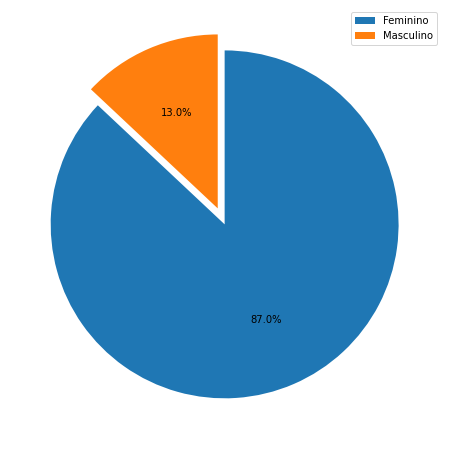

In [ ]:
fig, ax1 = plt.subplots(figsize = (8,8)) 
plt.pie(gender, explode = (0, 0.1), startangle=90, autopct='%1.1f%%', counterclock=False)
plt.legend(['Feminino', 'Masculino'],loc= 'upper right')
plt.show()

## 4.1 - Undersampling

Balanceamento da base em relação às classes Feminino e Masculino

In [ ]:
#faz reamostragem para balancear as classes
nm = NearMiss()
X_res, y_res = nm.fit_resample(dfTudoProcessado.drop(columns=['gender']), dfTudoProcessado['gender'])

In [ ]:
#classes balanceadas
print(f'Base balanceada: {Counter(y_res)}')

Base balanceada: Counter({0: 1290, 1: 1290})


In [ ]:
#gera dataframe com os dados balanceados
dfBalanceado = pd.DataFrame(X_res, columns=dfTudoProcessado.columns.drop('gender'))

In [ ]:
#acrescenta coluna alvo
dfBalanceado['gender'] = pd.Series(y_res)

In [ ]:
#mostra quantidade de amostra de cada classe (feminino e masculino)
dfBalanceado['gender'].value_counts()

1    1290
0    1290
Name: gender, dtype: int64

In [ ]:
dfBalanceado

,ano,paginas,adulto,artes,autoajuda,aventura,biografia,comunicação,contos,crime,crônica,culinária,decoração,drama,economia,ensaios,entretenimento,erótico,fantasia,ficção,filosofia,história,infantil,infantojuvenil,brasileira,estrangeira,matemática,memórias,música,não-ficção,poesias,policial,política,psicologia,religião,romance,saúde,sexo,sociologia,suspense,terror,viagens,ratingcurrent,resenhas,abandonos,relendo,querem_ler,lendo,leram,favoritos,desejados,trocam,avaliaram,gender
0,2012.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.7,0.0,0.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0,3.0,0
1,2008.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0
2,2008.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0,1.0,0.0,6.0,0.0,1.0,1.0,3.0,0
3,2008.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0
4,2006.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,0.0,10.0,1.0,14.0,1.0,3.0,0.0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2010.0,184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,23.0,55.0,5.0,1163.0,227.0,1705.0,70.0,166.0,14.0,803.0,1
2576,2009.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.6,5.0,0.0,1.0,144.0,19.0,87.0,2.0,5.0,1.0,46.0,1
2577,2008.0,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.8,0.0,2.0,0.0,36.0,1.0,30.0,1.0,2.0,1.0,16.0,1
2578,2008.0,177.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,0.0,1.0,0.0,50.0,7.0,41.0,2.0,2.0,4.0,25.0,1


In [ ]:
#lista dos gêneros presentes na base
generosLiterarios = ['adulto', 'artes', 'autoajuda', 'aventura', 'biografia', 'comunicação', 'contos', 'crime', 'crônica', 'culinária', 'decoração', 'drama', 'economia', 'ensaios', 'entretenimento', 'erótico', 'fantasia', 'ficção', 'filosofia', 'história', 'infantil', 'infantojuvenil', 'brasileira', 'estrangeira', 'matemática', 'memórias', 'música', 'não-ficção', 'poesias', 'policial', 'política', 'psicologia', 'religião', 'romance', 'saúde', 'sexo', 'sociologia', 'suspense', 'terror', 'viagens']

In [ ]:
#cria uma série com a quantidade de amostras de cada gênero e seus nomes
qtdGeneros = pd.Series(dfBalanceado[generosLiterarios].sum(), index=dfBalanceado[generosLiterarios].sum().index)

In [ ]:
#Percorre série criada anteriormente para remover as colunas com 0 ocorrências
for i, v in qtdGeneros.items():
    if v == 0:
      dfBalanceado.drop(columns=[i], inplace=True)

In [ ]:
#guarda base balanceada
dfBalanceado.to_csv('./basebalanceada.csv',index=False)

## 4.2 - Análise Exploratória com a base balanceada

In [ ]:
dfBalanceado = pd.read_csv('./basebalanceada.csv')

In [ ]:
dfBalanceado.columns

Index(['ano', 'paginas', 'adulto', 'artes', 'autoajuda', 'aventura',
       'biografia', 'comunicação', 'contos', 'crime', 'culinária', 'decoração',
       'drama', 'economia', 'ensaios', 'entretenimento', 'erótico', 'fantasia',
       'ficção', 'filosofia', 'história', 'infantil', 'infantojuvenil',
       'brasileira', 'estrangeira', 'matemática', 'memórias', 'música',
       'não-ficção', 'poesias', 'policial', 'política', 'psicologia',
       'religião', 'romance', 'saúde', 'sexo', 'sociologia', 'suspense',
       'terror', 'viagens', 'ratingcurrent', 'resenhas', 'abandonos',
       'relendo', 'querem_ler', 'lendo', 'leram', 'favoritos', 'desejados',
       'trocam', 'avaliaram', 'gender'],
      dtype='object')

In [ ]:
#Lista com gêneros presentes na base após balanceamento
generosLiterarios = ['adulto', 'artes', 'autoajuda', 'aventura',
       'biografia', 'comunicação', 'contos', 'crime', 'culinária', 'decoração',
       'drama', 'economia', 'ensaios', 'entretenimento', 'erótico', 'fantasia',
       'ficção', 'filosofia', 'história', 'infantil', 'infantojuvenil',
       'brasileira', 'estrangeira', 'matemática', 'memórias', 'música',
       'não-ficção', 'poesias', 'policial', 'política', 'psicologia',
       'religião', 'romance', 'saúde', 'sexo', 'sociologia', 'suspense',
       'terror', 'viagens']

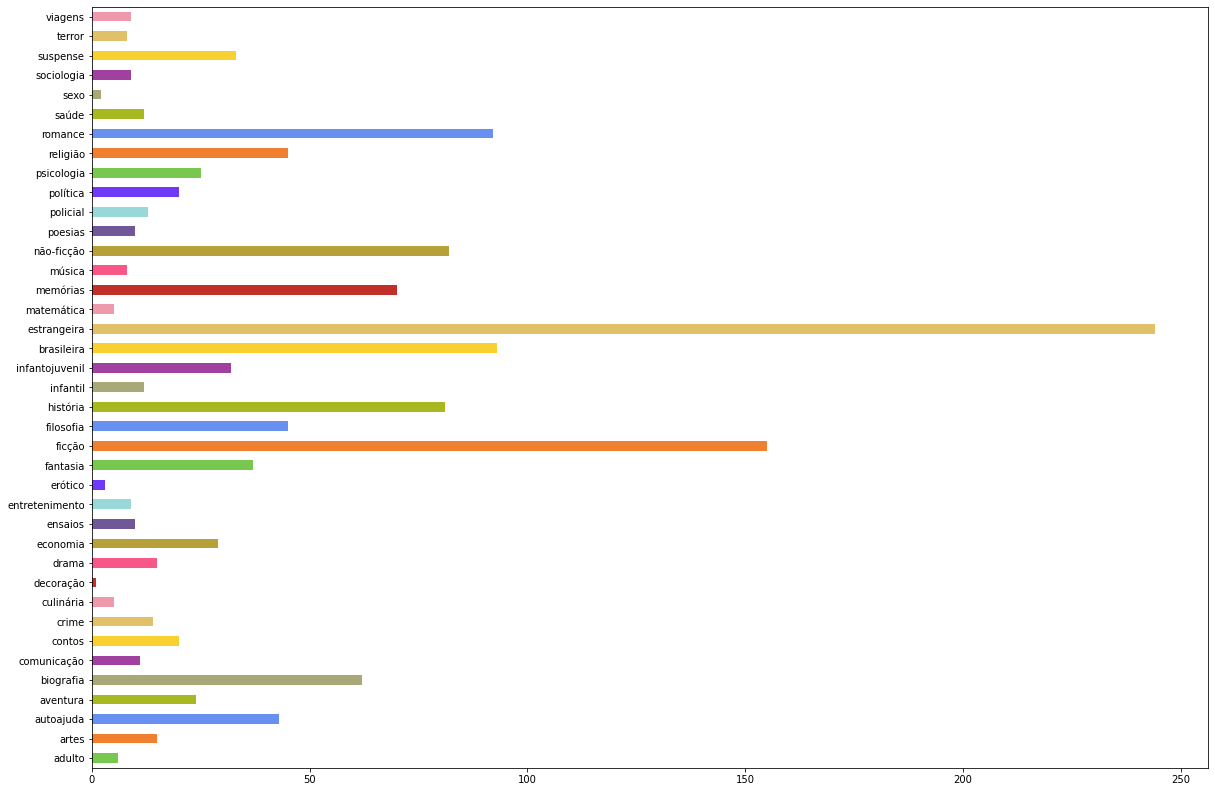

In [ ]:
#Mostra quantidade de amostras em cada gênero
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
dfBalanceado[generosLiterarios].sum().plot(kind='barh', figsize=(20, 14), color= pkmn_type_colors)

In [ ]:
#calcula correlações entre as colunas da base
corr = dfBalanceado.corr()

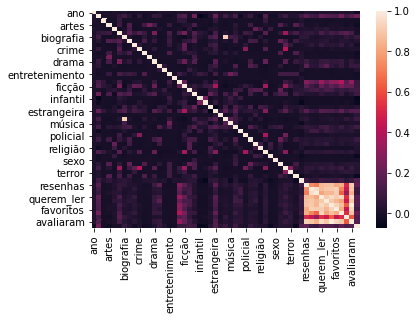

In [ ]:
#apresenta correlações positivas
sns.heatmap(corr)

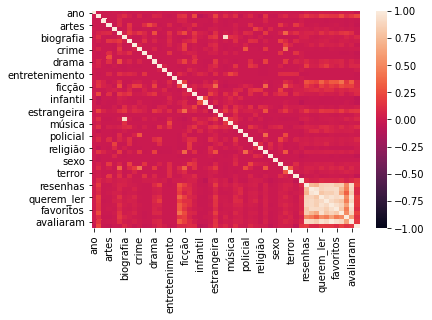

In [ ]:
#apresenta correlações positivas e negativas
sns.heatmap(corr, vmin = -1)

In [ ]:
#lista das colunas com valores quantitivos da base
grupoquantitativo = ['gender','resenhas', 'abandonos', 'relendo', 'querem_ler', 'lendo', 'leram', 'favoritos', 'desejados', 'trocam', 'avaliaram']

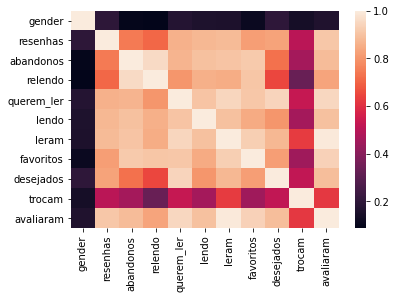

In [ ]:
#apresenta correlações entre as colunas quantitativas
sns.heatmap(dfBalanceado[grupoquantitativo].corr())

In [ ]:
#Lista com gêneros presentes na base após balanceamento
grupoliterario = ['gender'] + generosLiterarios.copy()

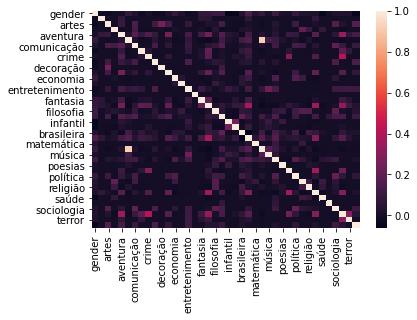

In [ ]:
#apresenta correlações entre os gêneros literários
sns.heatmap(dfBalanceado[grupoliterario].corr())

# 5 - Predição

Aplicando algoritmos Naive, KNN e SVM



In [ ]:
#Predições com a base balanceada
dfBalanceado = pd.read_csv('./basebalanceada.csv')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Esta classe possui métodos para:
#Executar o holdout (avaliamodelo); 
#Guardar as métricas de cada execução (armazenametricas) e 
#Mostrar os valores médios com desvio padrão para as métricas (mostraresultadomedio),
#considerando que o holdout será executado n vezes (amostragem aleatória)
class runmodel:

  def __init__(self, X, y, model, n = 1):
    
    self.__resultados = {
      'precision_0': [],
      'recall_0': [],
      'f1_0': [],
      'support_0': [],
      'precision_1': [],
      'recall_1': [],
      'f1_1': [],
      'support_1' : [],
      'accuracy' : [],
      'precision_wavg' : [],
      'recall_wavg' : [],
      'f1_wavg' : [],
      'support_wavg' : []
    }

    for i in range(n):
      self.__avaliamodelo(X, y, model)

  @property
  def resultados(self):
    return self.__resultados

  def __avaliamodelo(self, X, y, model):
    #gera as amostras de treino (2/3) e teste (1/3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    # Treina o modelo usando os dados de treino
    model.fit(X_train,y_train)
    # Testa modelo usando os dados de teste
    pred = model.predict(X_test)
    #armazena resultado
    self.__armazenametricas(metrics.classification_report(y_test,pred, output_dict= True))

  def __armazenametricas(self, d):
    self.__resultados['precision_0'].append(d['0']['precision'])
    self.__resultados['recall_0'].append(d['0']['recall'])
    self.__resultados['f1_0'].append(d['0']['f1-score'])
    self.__resultados['support_0'].append(d['0']['support'])

    self.__resultados['precision_1'].append(d['1']['precision'])
    self.__resultados['recall_1'].append(d['1']['recall'])
    self.__resultados['f1_1'].append(d['1']['f1-score'])
    self.__resultados['support_1'].append(d['1']['support'])

    self.__resultados['accuracy'].append(d['accuracy'])
    
    self.__resultados['precision_wavg'].append(d['weighted avg']['precision'])
    self.__resultados['recall_wavg'].append(d['weighted avg']['recall'])
    self.__resultados['f1_wavg'].append(d['weighted avg']['f1-score'])
    self.__resultados['support_wavg'].append(d['weighted avg']['support'])

  def mostraresultadomedio(self):
    print(f"\t\t precision \t recall \t f1-score \t support\n")
    print(f"0 \t\t {round(np.mean(self.__resultados['precision_0']), 2)}({round(np.std(self.__resultados['precision_0']),2)}) \t {round(np.mean(self.__resultados['recall_0']),2)}({round(np.std(self.__resultados['recall_0']),2)}) \t {round(np.mean(self.__resultados['f1_0']),2)}({round(np.std(self.__resultados['f1_0']),2)}) \t {round(np.mean(self.__resultados['support_0']),2)}({round(np.std(self.__resultados['support_0']),2)})\n")
    print(f"1 \t\t {round(np.mean(self.__resultados['precision_1']), 2)}({round(np.std(self.__resultados['precision_1']),2)}) \t {round(np.mean(self.__resultados['recall_1']),2)}({round(np.std(self.__resultados['recall_1']),2)}) \t {round(np.mean(self.__resultados['f1_1']),2)}({round(np.std(self.__resultados['f1_1']),2)}) \t {round(np.mean(self.__resultados['support_1']),2)}({round(np.std(self.__resultados['support_1']),2)})\n")
    print(f"accuracy \t\t  \t\t  \t {round(np.mean(self.__resultados['accuracy']), 2)}({round(np.std(self.__resultados['accuracy']),2)}) \t\t \n")
    print(f"weighted avg \t {round(np.mean(self.__resultados['precision_wavg']), 2)}({round(np.std(self.__resultados['precision_wavg']),2)}) \t {round(np.mean(self.__resultados['recall_wavg']),2)}({round(np.std(self.__resultados['recall_wavg']),2)}) \t {round(np.mean(self.__resultados['f1_wavg']),2)}({round(np.std(self.__resultados['f1_wavg']),2)}) \t {round(np.mean(self.__resultados['support_wavg']),2)}({round(np.std(self.__resultados['support_wavg']),2)})\n")

## 5.1 - Naive

### Executa 30 holdouts para o naive bayes

In [ ]:
naive = runmodel(dfBalanceado.drop(columns = ['gender']), dfBalanceado['gender'], GaussianNB(), 30)
print('\tMédia e desvio padrão de 30 execuções do Naive Bayes com amostragem aleatória\n')
naive.mostraresultadomedio()

	Média e desvio padrão de 30 execuções do Naive Bayes com amostragem aleatória

		 precision 	 recall 	 f1-score 	 support

0 		 0.65(0.02) 	 0.96(0.01) 	 0.78(0.01) 	 425.83(12.98)

1 		 0.93(0.02) 	 0.49(0.03) 	 0.64(0.02) 	 426.17(12.98)

accuracy 		  		  	 0.72(0.01) 		 

weighted avg 	 0.79(0.01) 	 0.72(0.01) 	 0.71(0.02) 	 852.0(0.0)



In [ ]:
#guarda resultados das 30 execuções do naive
pd.DataFrame(naive.resultados).to_csv('./resultadosnaive.csv',index=False)

## 5.2 - KNN

### Definição dos melhores parâmetros para o KNN usando gridsearchcv




In [ ]:
#define os parâmetros a serem testados com o KNN
param_grid_knn = {'n_neighbors': range(1,40,2), 'weights': ['uniform', 'distance']} 
#cria o objeto do gridsearchcv
gridknn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring = 'f1_weighted', cv = 10, verbose = 1)
#executa o gridsearchcv para a base separando X e y
gridknn.fit(dfBalanceado.drop(columns = ['gender']), dfBalanceado['gender'])

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   13.0s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 40, 2),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=1)

In [ ]:
gridknn.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=37, p=2,
                     weights='uniform')

### Executa 30 holdouts para o KNN com os parâmetros encontrados





In [ ]:
knn = runmodel(dfBalanceado.drop(['gender'], axis=1), dfBalanceado['gender'], gridknn.best_estimator_, 30)
print('\tMédia e desvio padrão de 30 execuções do KNN com amostragem aleatória\n')
knn.mostraresultadomedio()

	Média e desvio padrão de 30 execuções do KNN com amostragem aleatória

		 precision 	 recall 	 f1-score 	 support

0 		 0.7(0.02) 	 0.95(0.01) 	 0.81(0.01) 	 432.4(12.56)

1 		 0.93(0.02) 	 0.59(0.02) 	 0.72(0.02) 	 419.6(12.56)

accuracy 		  		  	 0.77(0.01) 		 

weighted avg 	 0.81(0.01) 	 0.77(0.01) 	 0.76(0.01) 	 852.0(0.0)



In [ ]:
#guarda resultados das 30 execuções do knn
pd.DataFrame(knn.resultados).to_csv('./resultadosknn.csv',index=False)

## 5.3 - SVM

### Definição dos melhores parâmetros para o SVM usando gridsearchcv

In [ ]:
#define os parâmetros a serem testados com o SVM
param_grid_svm = {'C': [1,10,100], 'gamma': [0.1,0.01,0.001]} 
#cria o objeto do gridsearchcv
gridsvm = GridSearchCV(SVC(), param_grid_svm, scoring = 'f1_weighted', cv = 10, verbose = 1)
#executa o gridsearchcv para a base separando X e y
gridsvm.fit(dfBalanceado.drop(['gender'], axis=1), dfBalanceado['gender'])

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=1)

In [ ]:
gridsvm.best_params_

{'C': 1, 'gamma': 0.001}

### Executa 30 holdouts para o SVM com os parâmetros encontrados

In [ ]:
svm = runmodel(dfBalanceado.drop(['gender'], axis=1), dfBalanceado['gender'], grid.best_estimator_, 30)
print('\tMédia e desvio padrão de 30 execuções do SVM com amostragem aleatória\n')
svm.mostraresultadomedio()

	Média e desvio padrão de 30 execuções do SVM com amostragem aleatória

		 precision 	 recall 	 f1-score 	 support

0 		 0.71(0.02) 	 0.94(0.01) 	 0.81(0.01) 	 428.07(13.34)

1 		 0.91(0.02) 	 0.62(0.02) 	 0.74(0.01) 	 423.93(13.34)

accuracy 		  		  	 0.78(0.01) 		 

weighted avg 	 0.81(0.01) 	 0.78(0.01) 	 0.77(0.01) 	 852.0(0.0)



In [ ]:
#guarda resultados das 30 execuções do svm
pd.DataFrame(svm.resultados).to_csv('./resultadossvm.csv',index=False)

## Teste de Hipótese

Compara os modelos para identificar se existe diferença estatística entre eles

*   Hipótese nula considerada: Os modelos tem desempenho igual.
*   Hipótese alternativa considerada: Os modelos tem desempenho diferente.
*    Limiar de probabilidade (alfa): 5% (0.05)

Caso o p-value seja menor que o limiar, aceitaremos a hipótese alternativa.

### SVM x KNN

In [ ]:
help(stats.ttest_ind)

Help on function ttest_ind in module scipy.stats.stats:

ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
    Calculate the T-test for the means of *two independent* samples of scores.
    
    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.
    
    Parameters
    ----------
    a, b : array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int or None, optional
        Axis along which to compute test. If None, compute over the whole
        arrays, `a`, and `b`.
    equal_var : bool, optional
        If True (default), perform a standard independent 2 sample test
        that assumes equal population variances [1]_.
        If False, perform Welch's t-test, which does not assume equal
        population variance [2]_.
    
   

In [ ]:
t_svmknn, p_svmknn = stats.ttest_ind(svm.resultados['accuracy'], knn.resultados['accuracy'])

In [ ]:
print(f't value SVM x KNN: {t_svmknn} \t p value SVM x KNN: {p_svmknn}')

t value SVM x KNN: 2.5799327123267934 	 p value SVM x KNN: 0.01243719600686404


In [ ]:
if p_svmknn < 0.05:
  print('Hipótese nula rejeitada. O desempenho dos modelos é estatisticamente diferente')

Hipótese nula rejeitada. O desempenho dos modelos é estatisticamente diferente


### SVM x Naive

In [ ]:
t_svmnaive, p_svmnaive = stats.ttest_ind(svm.resultados['accuracy'], naive.resultados['accuracy'])

In [ ]:
print(f't value SVM x Naive: {t_svmnaive} \t p value SVM x Naive: {p_svmnaive}')

t value SVM x Naive: 17.03140088681362 	 p value SVM x Naive: 3.0734846871173005e-24


In [ ]:
if p_svmnaive < 0.05:
  print('Hipótese nula rejeitada. O desempenho dos modelos é estatisticamente diferente')

Hipótese nula rejeitada. O desempenho dos modelos é estatisticamente diferente


### KNN x Naive

In [ ]:
t_knnnaive, p_knnnaive = stats.ttest_ind(knn.resultados['accuracy'], naive.resultados['accuracy'])

In [ ]:
print(f't value KNN x Naive: {t_knnnaive} \t p value KNN x Naive: {p_knnnaive}')

t value KNN x Naive: 13.855125123914018 	 p value KNN x Naive: 4.7256584535864414e-20


In [ ]:
if p_knnnaive < 0.05:
  print('Hipótese nula rejeitada. O desempenho dos modelos é estatisticamente diferente')

Hipótese nula rejeitada. O desempenho dos modelos é estatisticamente diferente
